<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/5.%20Modelling/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB

# tensorflow for nn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 240)

# Plotting Function
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

In [2]:
!wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/clean_data.csv' -O clean_data.csv

data = pd.read_csv('clean_data.csv')
data.shape

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


(780, 52)

In [3]:
X = data.drop('Diagnosis', axis=1)  # Features
y = data['Diagnosis']               # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((624, 51), (156, 51), (624,), (156,))

In [4]:
# Results storage for confusion matrices, classification reports, and ROC curves
models = []
confusion_matrices = []
roc_curves = []
accuracy = []
precision = []
recall = []
f1 = []
tpr = []
fpr = []
tnr = []
fnr = []

## Logistic Regression

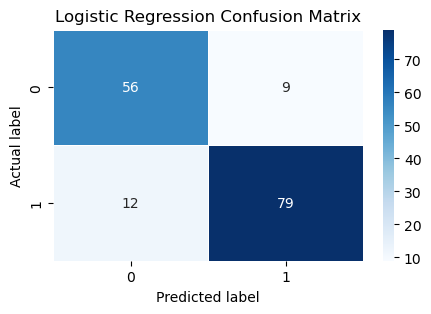

 
True Positive Rate: 0.8681
False Positive Rate: 0.1385
True Negative Rate: 0.8615
False Negative Rate: 0.1319
 
5-fold CV:
Accuracy: 0.883
Precision: 0.9077
Recall: 0.8949
F1: 0.9007


In [5]:
# Model & pipeline
lr_model = LogisticRegression(max_iter=1000, random_state=123)
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', lr_model)])
models.append('Logistic Regression')

# Create confusion matrix
lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred)
confusion_matrices.append(cm_lr)

# 5 fold CV
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculate Scores
cv_scores_accuracy = cross_val_score(lr_pipeline, X_train, y_train, cv=k_fold, scoring="accuracy")
mean_cv_accuracy = cv_scores_accuracy.mean()
accuracy.append(mean_cv_accuracy)

cv_scores_precision = cross_val_score(lr_pipeline, X_train, y_train, cv=k_fold, scoring="precision")
mean_cv_precision = cv_scores_precision.mean()
precision.append(mean_cv_precision)

cv_scores_recall = cross_val_score(lr_pipeline, X_train, y_train, cv=k_fold, scoring="recall")
mean_cv_recall = cv_scores_recall.mean()
recall.append(mean_cv_recall)

cv_scores_f1 = cross_val_score(lr_pipeline, X_train, y_train, cv=k_fold, scoring="f1")
mean_cv_f1 = cv_scores_f1.mean()
f1.append(mean_cv_f1)

# Calculate ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pipeline.predict_proba(X_test)[:, 1])
roc_curves.append((fpr_lr, tpr_lr))

# Calculating false negative rate
tn, fp, fn, tp = cm_lr.ravel()
true_positive_rate = tp / (tp + fn)
false_positive_rate = fp / (fp + tn)
true_negative_rate = tn / (tn + fp)
false_negative_rate = fn / (fn + tp)

tpr.append(true_positive_rate)
fpr.append(false_positive_rate)
tnr.append(true_negative_rate)
fnr.append(false_negative_rate)

plot_confusion_matrix(cm_lr, "Logistic Regression Confusion Matrix")
print(" ")
print("True Positive Rate:", round(true_positive_rate,4))
print("False Positive Rate:", round(false_positive_rate,4))
print("True Negative Rate:", round(true_negative_rate,4))
print("False Negative Rate:", round(false_negative_rate,4))
print(" ")
print("5-fold CV:")
print("Accuracy:", round(mean_cv_accuracy,4))
print("Precision:", round(mean_cv_precision,4))
print("Recall:", round(mean_cv_recall,4))
print("F1:", round(mean_cv_f1,4))

## Naive Bayes Classifier

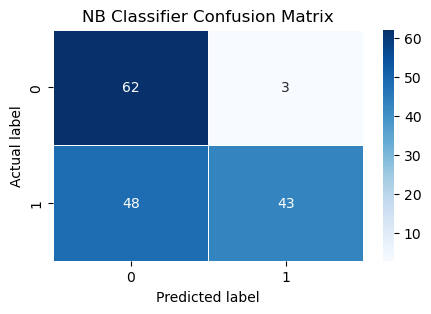

 
True Positive Rate: 0.4725
False Positive Rate: 0.0462
True Negative Rate: 0.9538
False Negative Rate: 0.5275
 
5-fold CV:
Accuracy: 0.6458
Precision: 0.9442
Recall: 0.4287
F1: 0.5891


In [6]:
# Model & pipeline
nb_model = GaussianNB()
nb_pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', nb_model)])
models.append('Naive Bayes')

# Create confusion matrix
nb_pipeline.fit(X_train, y_train)
y_pred = nb_pipeline.predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred)
confusion_matrices.append(cm_nb)

# 5 fold CV
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculate Scores
cv_scores_accuracy = cross_val_score(nb_pipeline, X_train, y_train, cv=k_fold, scoring="accuracy")
mean_cv_accuracy = cv_scores_accuracy.mean()
accuracy.append(mean_cv_accuracy)

cv_scores_precision = cross_val_score(nb_pipeline, X_train, y_train, cv=k_fold, scoring="precision")
mean_cv_precision = cv_scores_precision.mean()
precision.append(mean_cv_precision)

cv_scores_recall = cross_val_score(nb_pipeline, X_train, y_train, cv=k_fold, scoring="recall")
mean_cv_recall = cv_scores_recall.mean()
recall.append(mean_cv_recall)

cv_scores_f1 = cross_val_score(nb_pipeline, X_train, y_train, cv=k_fold, scoring="f1")
mean_cv_f1 = cv_scores_f1.mean()
f1.append(mean_cv_f1)

# Calculate ROC curve
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_pipeline.predict_proba(X_test)[:, 1])
roc_curves.append((fpr_nb, tpr_nb))

# Calculating false negative rate
tn, fp, fn, tp = cm_nb.ravel()
true_positive_rate = tp / (tp + fn)
false_positive_rate = fp / (fp + tn)
true_negative_rate = tn / (tn + fp)
false_negative_rate = fn / (fn + tp)

tpr.append(true_positive_rate)
fpr.append(false_positive_rate)
tnr.append(true_negative_rate)
fnr.append(false_negative_rate)

plot_confusion_matrix(cm_nb, "NB Classifier Confusion Matrix")
print(" ")
print("True Positive Rate:", round(true_positive_rate,4))
print("False Positive Rate:", round(false_positive_rate,4))
print("True Negative Rate:", round(true_negative_rate,4))
print("False Negative Rate:", round(false_negative_rate,4))
print(" ")
print("5-fold CV:")
print("Accuracy:", round(mean_cv_accuracy,4))
print("Precision:", round(mean_cv_precision,4))
print("Recall:", round(mean_cv_recall,4))
print("F1:", round(mean_cv_f1,4))

## Support Vector Machine

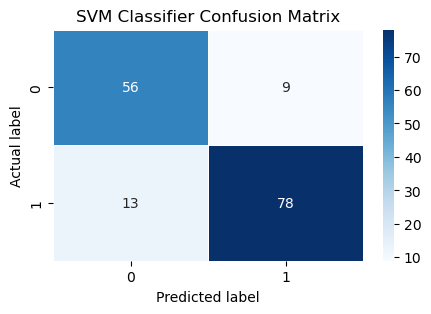

 
True Positive Rate: 0.8571
False Positive Rate: 0.1385
True Negative Rate: 0.8615
False Negative Rate: 0.1429
 
5-fold CV:
Accuracy: 0.867
Precision: 0.8966
Recall: 0.8803
F1: 0.8879


In [7]:
# Model & pipeline
svm_model = SVC(kernel='rbf', random_state=123, probability=True)
svm_pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', svm_model)])
models.append('SVM')

# Create confusion matrix
svm_pipeline.fit(X_train, y_train)
y_pred = svm_pipeline.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred)
confusion_matrices.append(cm_svm)

# 5 fold CV
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculate Scores
cv_scores_accuracy = cross_val_score(svm_pipeline, X_train, y_train, cv=k_fold, scoring="accuracy")
mean_cv_accuracy = cv_scores_accuracy.mean()
accuracy.append(mean_cv_accuracy)

cv_scores_precision = cross_val_score(svm_pipeline, X_train, y_train, cv=k_fold, scoring="precision")
mean_cv_precision = cv_scores_precision.mean()
precision.append(mean_cv_precision)

cv_scores_recall = cross_val_score(svm_pipeline, X_train, y_train, cv=k_fold, scoring="recall")
mean_cv_recall = cv_scores_recall.mean()
recall.append(mean_cv_recall)

cv_scores_f1 = cross_val_score(svm_pipeline, X_train, y_train, cv=k_fold, scoring="f1")
mean_cv_f1 = cv_scores_f1.mean()
f1.append(mean_cv_f1)

# Calculate ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_pipeline.predict_proba(X_test)[:, 1])
roc_curves.append((fpr_svm, tpr_svm))

# Calculating Rates
tn, fp, fn, tp = cm_svm.ravel()
true_positive_rate = tp / (tp + fn)
false_positive_rate = fp / (fp + tn)
true_negative_rate = tn / (tn + fp)
false_negative_rate = fn / (fn + tp)

tpr.append(true_positive_rate)
fpr.append(false_positive_rate)
tnr.append(true_negative_rate)
fnr.append(false_negative_rate)

plot_confusion_matrix(cm_svm, "SVM Classifier Confusion Matrix")
print(" ")
print("True Positive Rate:", round(true_positive_rate,4))
print("False Positive Rate:", round(false_positive_rate,4))
print("True Negative Rate:", round(true_negative_rate,4))
print("False Negative Rate:", round(false_negative_rate,4))
print(" ")
print("5-fold CV:")
print("Accuracy:", round(mean_cv_accuracy,4))
print("Precision:", round(mean_cv_precision,4))
print("Recall:", round(mean_cv_recall,4))
print("F1:", round(mean_cv_f1,4))

## Random Forest Classifier

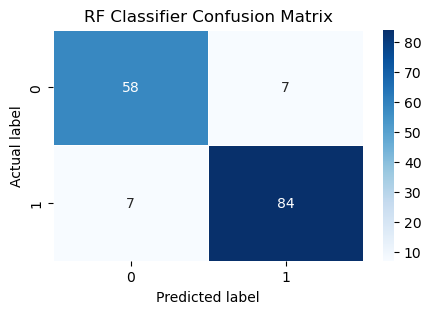

 
True Positive Rate: 0.9231
False Positive Rate: 0.1077
True Negative Rate: 0.8923
False Negative Rate: 0.0769
 
5-fold CV:
Accuracy: 0.9375
Precision: 0.9538
Recall: 0.9407
F1: 0.947


In [8]:
# Model & pipeline
rf_model = RandomForestClassifier(n_estimators=100, random_state=123)
rf_pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', rf_model)])
models.append('Random Forest')

# Create confusion matrix
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred)
confusion_matrices.append(cm_rf)

# 5 fold CV
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculate Scores
cv_scores_accuracy = cross_val_score(rf_pipeline, X_train, y_train, cv=k_fold, scoring="accuracy")
mean_cv_accuracy = cv_scores_accuracy.mean()
accuracy.append(mean_cv_accuracy)

cv_scores_precision = cross_val_score(rf_pipeline, X_train, y_train, cv=k_fold, scoring="precision")
mean_cv_precision = cv_scores_precision.mean()
precision.append(mean_cv_precision)

cv_scores_recall = cross_val_score(rf_pipeline, X_train, y_train, cv=k_fold, scoring="recall")
mean_cv_recall = cv_scores_recall.mean()
recall.append(mean_cv_recall)

cv_scores_f1 = cross_val_score(rf_pipeline, X_train, y_train, cv=k_fold, scoring="f1")
mean_cv_f1 = cv_scores_f1.mean()
f1.append(mean_cv_f1)

# Calculate ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
roc_curves.append((fpr_rf, tpr_rf))

# Calculating Rates
tn, fp, fn, tp = cm_rf.ravel()
true_positive_rate = tp / (tp + fn)
false_positive_rate = fp / (fp + tn)
true_negative_rate = tn / (tn + fp)
false_negative_rate = fn / (fn + tp)

tpr.append(true_positive_rate)
fpr.append(false_positive_rate)
tnr.append(true_negative_rate)
fnr.append(false_negative_rate)

plot_confusion_matrix(cm_rf, "RF Classifier Confusion Matrix")
print(" ")
print("True Positive Rate:", round(true_positive_rate,4))
print("False Positive Rate:", round(false_positive_rate,4))
print("True Negative Rate:", round(true_negative_rate,4))
print("False Negative Rate:", round(false_negative_rate,4))
print(" ")
print("5-fold CV:")
print("Accuracy:", round(mean_cv_accuracy,4))
print("Precision:", round(mean_cv_precision,4))
print("Recall:", round(mean_cv_recall,4))
print("F1:", round(mean_cv_f1,4))

## Gradient Boosting Classifier

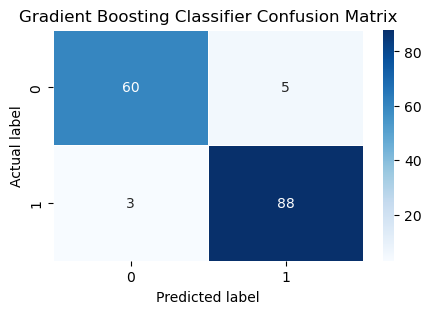

 
True Positive Rate: 0.967
False Positive Rate: 0.0769
True Negative Rate: 0.9231
False Negative Rate: 0.033
 
5-fold CV:
Accuracy: 0.9503
Precision: 0.9626
Recall: 0.9528
F1: 0.9572


In [9]:
# Model & pipeline
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=123)
gb_pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', gb_model)])
models.append('Gradient Boosting')

# Create confusion matrix
gb_pipeline.fit(X_train, y_train)
y_pred = gb_pipeline.predict(X_test)
cm_gb = confusion_matrix(y_test, y_pred)
confusion_matrices.append(cm_gb)

# 5 fold CV
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculate Scores
cv_scores_accuracy = cross_val_score(gb_pipeline, X_train, y_train, cv=k_fold, scoring="accuracy")
mean_cv_accuracy = cv_scores_accuracy.mean()
accuracy.append(mean_cv_accuracy)

cv_scores_precision = cross_val_score(gb_pipeline, X_train, y_train, cv=k_fold, scoring="precision")
mean_cv_precision = cv_scores_precision.mean()
precision.append(mean_cv_precision)

cv_scores_recall = cross_val_score(gb_pipeline, X_train, y_train, cv=k_fold, scoring="recall")
mean_cv_recall = cv_scores_recall.mean()
recall.append(mean_cv_recall)

cv_scores_f1 = cross_val_score(gb_pipeline, X_train, y_train, cv=k_fold, scoring="f1")
mean_cv_f1 = cv_scores_f1.mean()
f1.append(mean_cv_f1)

# Calculate ROC curve
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_pipeline.predict_proba(X_test)[:, 1])
roc_curves.append((fpr_gb, tpr_gb))

# Calculating Rates
tn, fp, fn, tp = cm_gb.ravel()
true_positive_rate = tp / (tp + fn)
false_positive_rate = fp / (fp + tn)
true_negative_rate = tn / (tn + fp)
false_negative_rate = fn / (fn + tp)

tpr.append(true_positive_rate)
fpr.append(false_positive_rate)
tnr.append(true_negative_rate)
fnr.append(false_negative_rate)

plot_confusion_matrix(cm_gb, "Gradient Boosting Classifier Confusion Matrix")
print(" ")
print("True Positive Rate:", round(true_positive_rate,4))
print("False Positive Rate:", round(false_positive_rate,4))
print("True Negative Rate:", round(true_negative_rate,4))
print("False Negative Rate:", round(false_negative_rate,4))
print(" ")
print("5-fold CV:")
print("Accuracy:", round(mean_cv_accuracy,4))
print("Precision:", round(mean_cv_precision,4))
print("Recall:", round(mean_cv_recall,4))
print("F1:", round(mean_cv_f1,4))

## Neural Network

In [10]:
# Pipeline
nn_pipeline = Pipeline([('scaler', StandardScaler())])
models.append('Neural Network')

# Transform the data
X_train_prepared = nn_pipeline.fit_transform(X_train)
X_test_prepared = nn_pipeline.transform(X_test)

# Build a simple neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_prepared.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid because of binaray classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to record training metrics
class MetricsCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy.append(logs['accuracy'])

# Fit the neural network
history = model.fit(X_train_prepared, y_train, epochs=50, validation_split=0.1)

# Evaluate the model on the test set
loss, test_accuracy = model.evaluate(X_test_prepared, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Update your metrics list with neural network performance
accuracy.append(test_accuracy)  # Append test accuracy for NN

# Retrieve the confusion matrix and ROC curve from the neural network's predictions
y_pred_nn = (model.predict(X_test_prepared) > 0.5).astype("int32")
cm_nn = confusion_matrix(y_test, y_pred_nn)
confusion_matrices.append(cm_nn)

# Calculate ROC curve data and AUC for neural network
fpr_nn, tpr_nn, _ = roc_curve(y_test, model.predict(X_test_prepared).ravel())
roc_auc_nn = auc(fpr_nn, tpr_nn)
roc_curves.append((fpr_nn, tpr_nn))  # Store ROC curve data correctly

# Calculate precision, recall, and F1 score from confusion matrix
nn_precision = precision_score(y_test, y_pred_nn)
nn_recall = recall_score(y_test, y_pred_nn)
nn_f1 = f1_score(y_test, y_pred_nn)

# Append calculated metrics to their respective lists
precision.append(nn_precision)
recall.append(nn_recall)
f1.append(nn_f1)

# Calculate additional rates
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_nn).ravel()
nn_true_positive_rate = tp / (tp + fn)
nn_false_positive_rate = fp / (fp + tn)
nn_true_negative_rate = tn / (tn + fp)
nn_false_negative_rate = fn / (fn + tp)

tpr.append(nn_true_positive_rate)
fpr.append(nn_false_positive_rate)
tnr.append(nn_true_negative_rate)
fnr.append(nn_false_negative_rate)

# Print metrics for confirmation
print(" ")
print("Neural Network Metrics:")
print("Accuracy:", round(test_accuracy, 4))  # Ensure 'test_accuracy' is from model.evaluate()
print("Precision:", round(nn_precision, 4))
print("Recall:", round(nn_recall, 4))
print("F1 Score:", round(nn_f1, 4))
print("True Positive Rate:", round(nn_true_positive_rate, 4))
print("False Positive Rate:", round(nn_false_positive_rate, 4))
print("True Negative Rate:", round(nn_true_negative_rate, 4))
print("False Negative Rate:", round(nn_false_negative_rate, 4))

C:\Users\mariu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6498 - loss: 0.6220 - val_accuracy: 0.7460 - val_loss: 0.4640
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8442 - loss: 0.4032 - val_accuracy: 0.8095 - val_loss: 0.3784
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8849 - loss: 0.3253 - val_accuracy: 0.8730 - val_loss: 0.3233
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9111 - loss: 0.2802 - val_accuracy: 0.8889 - val_loss: 0.2940
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9279 - loss: 0.2233 - val_accuracy: 0.8730 - val_loss: 0.2824
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9443 - loss: 0.1873 - val_accuracy: 0.8730 - val_loss: 0.2692
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9505 - loss: 0.1653 - val_accuracy: 0.8730 - val_loss: 0.2721
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9691 - loss: 0.1335 - val_accuracy: 0.8571 - val_loss

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
 
Neural Network Metrics:
Accuracy: 0.8141
Precision: 0.8298
Recall: 0.8571
F1 Score: 0.8432
True Positive Rate: 0.8571
False Positive Rate: 0.2462
True Negative Rate: 0.7538
False Negative Rate: 0.1429


## Summary & Model Comparison

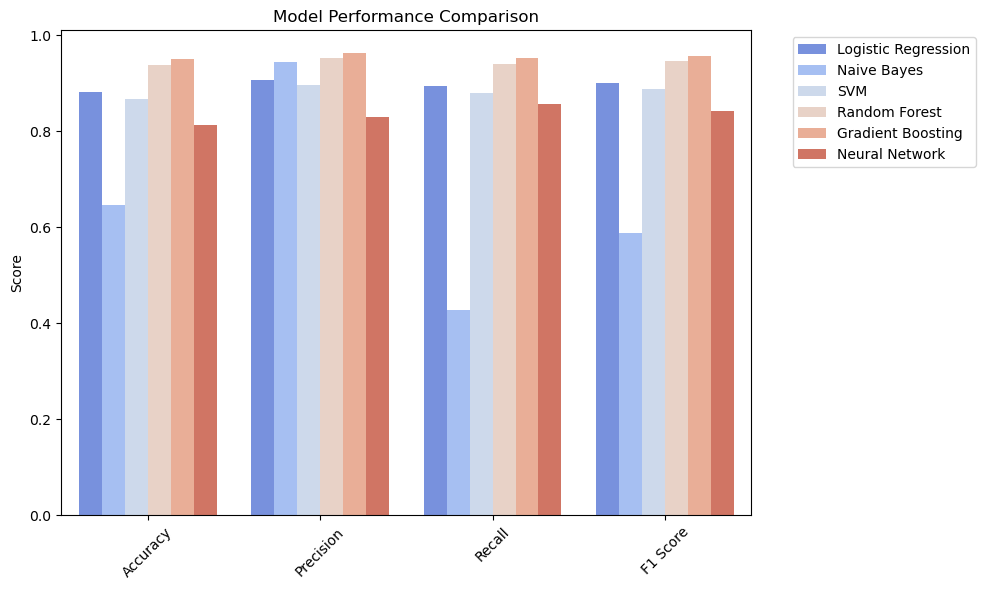

In [11]:
colors = sns.color_palette("coolwarm", len(models))

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [accuracy, precision, recall, f1]

data = {"Model": models}
for metric, metric_values in zip(metrics, values):
    data[metric] = metric_values
metrics_df = pd.DataFrame(data)

metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Model", palette=colors)
plt.title("Model Performance Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

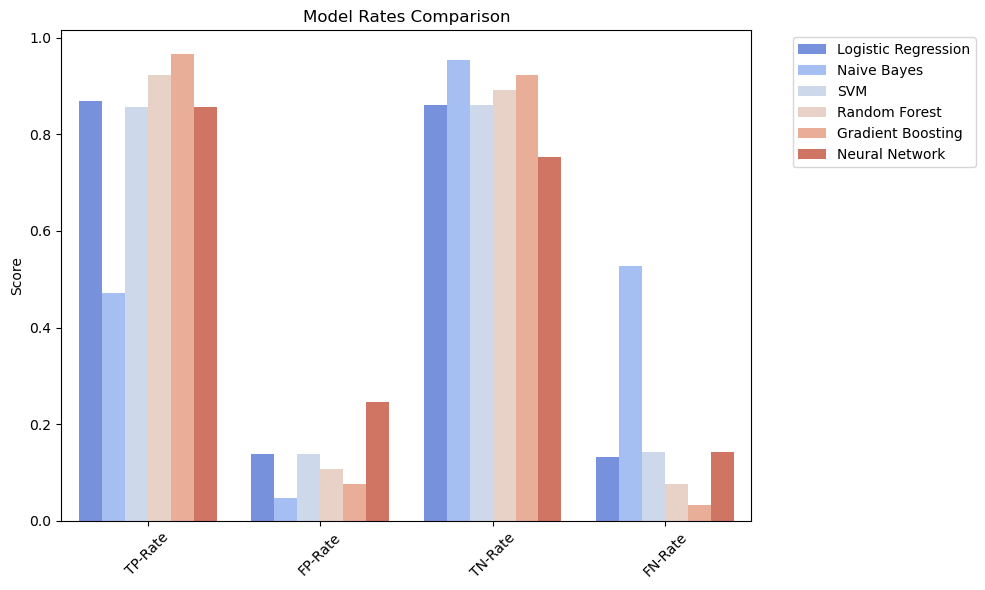

In [12]:
colors = sns.color_palette("coolwarm", len(models))

metrics = ["TP-Rate", "FP-Rate", "TN-Rate", "FN-Rate"]
values = [tpr, fpr, tnr, fnr]

data = {"Model": models}
for metric, metric_values in zip(metrics, values):
    data[metric] = metric_values
metrics_df = pd.DataFrame(data)

metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Model", palette=colors)
plt.title("Model Rates Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## AUC, ROC

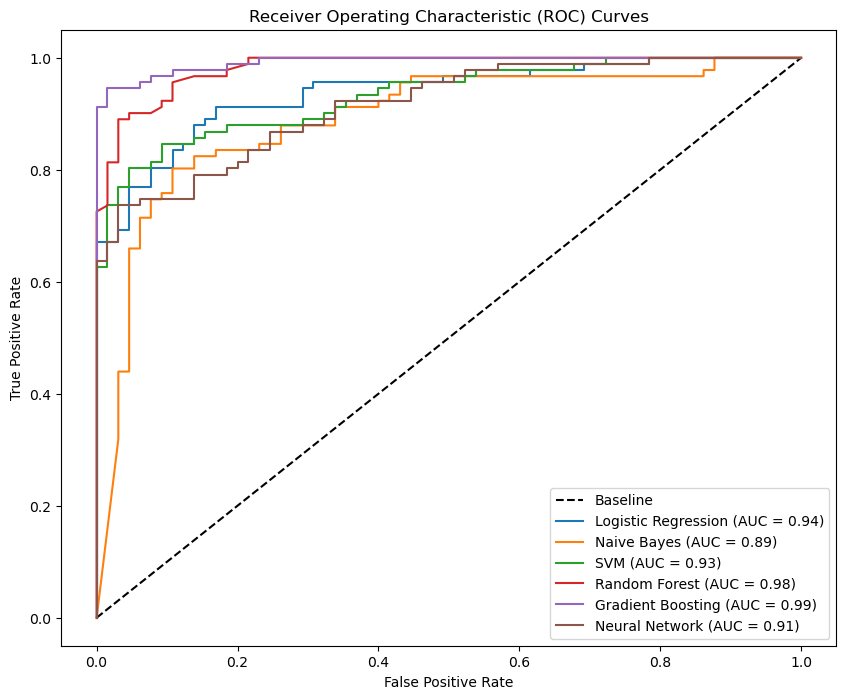

In [13]:
# Set up the figure
plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')

# Plot each model's ROC curve
for (fpr, tpr), model_name in zip(roc_curves, models):
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {model_auc:.2f})')

plt.legend(loc='lower right')
plt.show()